[Reference](https://towardsdatascience.com/three-approaches-to-feature-engineering-for-time-series-2123069567be)

In [1]:
!pip install sklego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 7.4 MB/s 
     |████████████████████████████████| 88 kB 7.8 MB/s 
     |████████████████████████████████| 1.1 MB 53.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=4a74b776da9a99fbfe1f1587ef0ee6069ffdb87eb620444234e5b069f8559077
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=ff8d54ded68dcf709e79da3912ea20d1162e6fdd1e6c385c70bfb1154e5d52ff
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklego.preprocessing import RepeatingBasisFunction

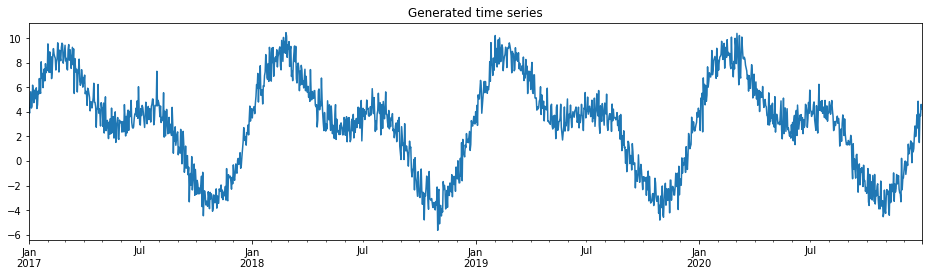

In [3]:
# for reproducibility
np.random.seed(42)
# generate the DataFrame with dates
range_of_dates = pd.date_range(start="2017-01-01",
                           	end="2020-12-30")
X = pd.DataFrame(index=range_of_dates)
# create a sequence of day numbers
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year
# generate the components of the target
signal_1 = 3 + 4 * np.sin(X["day_nr"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(X["day_nr"] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.85, len(X))
# combine them to get the target series
y = signal_1 + signal_2 + noise
# plot
y.plot(figsize=(16,4), title="Generated time series");

In [4]:
results_df = y.to_frame()
results_df.columns = ["actuals"]

In [5]:
TRAIN_END = 3 * 365


# Approach #1: dummy variables


In [6]:
X_1 = pd.DataFrame(
	data=pd.get_dummies(X.index.month, drop_first=True, prefix="month")
)
X_1.index = X.index
X_1

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2017-01-01,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0,0,0,0,0,0,0,0,0,0,1
2020-12-27,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,0,0,0,0,0,0,0,0,0,0,1


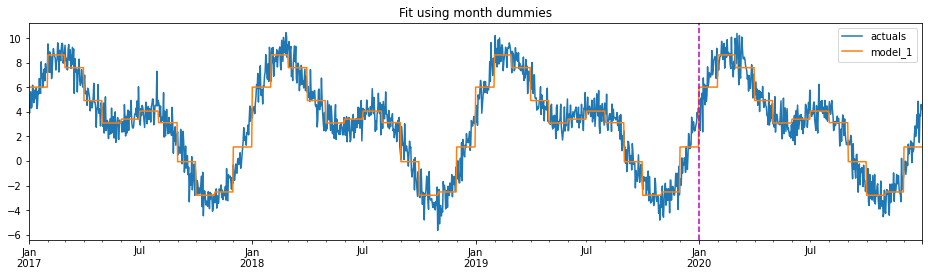

In [7]:
model_1 = LinearRegression().fit(X_1.iloc[:TRAIN_END],
                             	y.iloc[:TRAIN_END])
results_df["model_1"] = model_1.predict(X_1)
results_df[["actuals", "model_1"]].plot(figsize=(16,4),
                                    	title="Fit using month dummies")
plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

# Approach #2: cyclical encoding with sine/cosine transformation

In [8]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

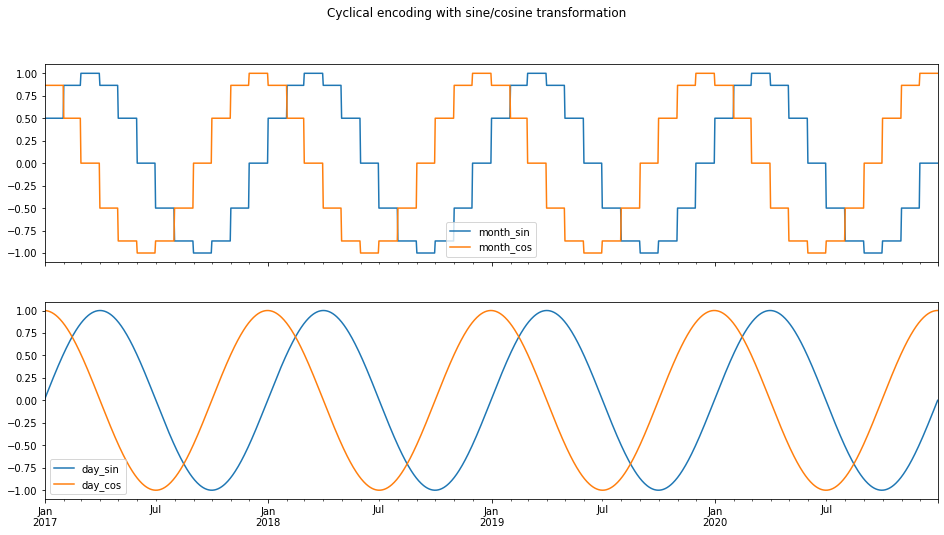

In [9]:
X_2 = X.copy()
X_2["month"] = X_2.index.month
X_2["month_sin"] = sin_transformer(12).fit_transform(X_2)["month"]
X_2["month_cos"] = cos_transformer(12).fit_transform(X_2)["month"]
X_2["day_sin"] = sin_transformer(365).fit_transform(X_2)["day_of_year"]
X_2["day_cos"] = cos_transformer(365).fit_transform(X_2)["day_of_year"]
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,8))
X_2[["month_sin", "month_cos"]].plot(ax=ax[0])
X_2[["day_sin", "day_cos"]].plot(ax=ax[1])
plt.suptitle("Cyclical encoding with sine/cosine transformation");

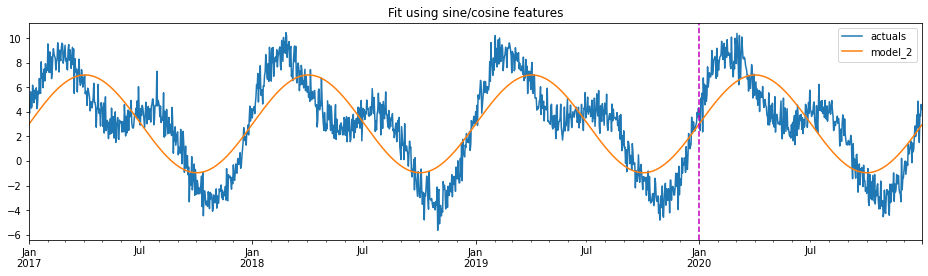

In [10]:
X_2_daily = X_2[["day_sin", "day_cos"]]
model_2 = LinearRegression().fit(X_2_daily.iloc[:TRAIN_END],
                             	y.iloc[:TRAIN_END])
results_df["model_2"] = model_2.predict(X_2_daily)
results_df[["actuals", "model_2"]].plot(figsize=(16,4),
                                    	title="Fit using sine/cosine features")
plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

# Approach #3: radial basis functions


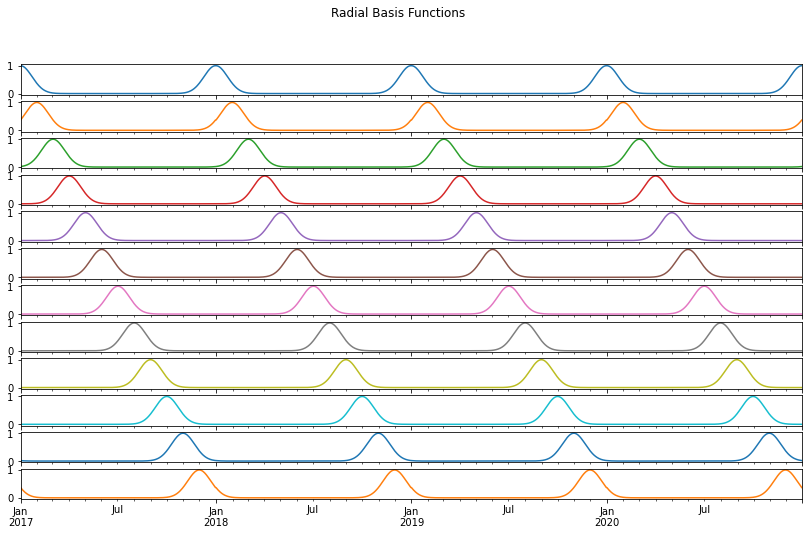

In [11]:
rbf = RepeatingBasisFunction(n_periods=12,
                         	column="day_of_year",
                         	input_range=(1,365),
                         	remainder="drop")
rbf.fit(X)
X_3 = pd.DataFrame(index=X.index,
               	data=rbf.transform(X))
X_3.plot(subplots=True, figsize=(14, 8),
     	sharex=True, title="Radial Basis Functions",
     	legend=False);

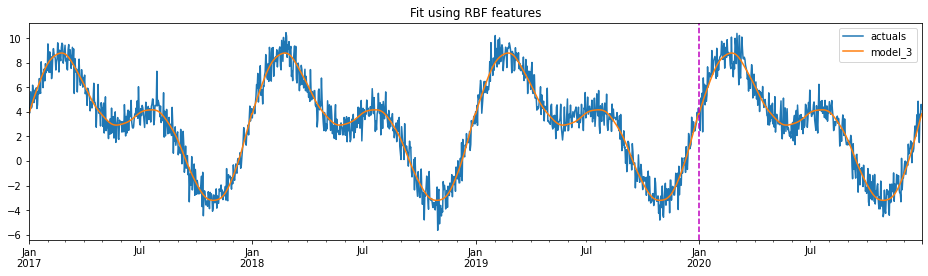

In [12]:
model_3 = LinearRegression().fit(X_3.iloc[:TRAIN_END],
                             	y.iloc[:TRAIN_END])
results_df["model_3"] = model_3.predict(X_3)
results_df[["actuals", "model_3"]].plot(figsize=(16,4),
                                    	title="Fit using RBF features")
plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

# Final comparison


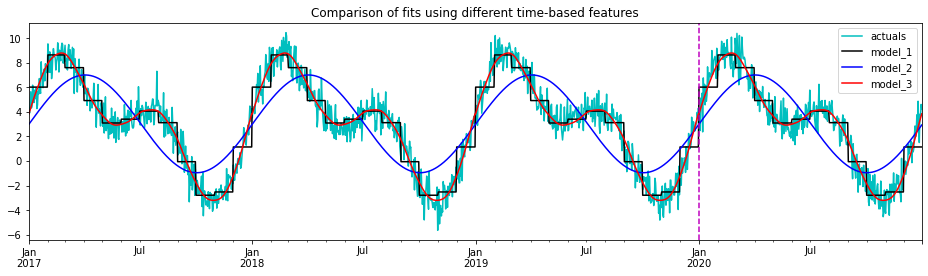

In [13]:
results_df.plot(title="Comparison of fits using different time-based features",
            	figsize=(16,4),
            	color = ["c", "k", "b", "r"])
plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

In [14]:
score_list = []
for fit_col in ["model_1", "model_2", "model_3"]:
	scores = {
    	"model": fit_col,
    	"train_score": mean_absolute_error(
        	results_df.iloc[:TRAIN_END]["actuals"],
        	results_df.iloc[:TRAIN_END][fit_col]
    	),
    	"test_score": mean_absolute_error(
        	results_df.iloc[TRAIN_END:]["actuals"],
        	results_df.iloc[TRAIN_END:][fit_col]
    	)
	}
	score_list.append(scores)
scores_df = pd.DataFrame(score_list)
scores_df

,model,train_score,test_score
0,model_1,0.876548,0.925758
1,model_2,1.976644,1.990182
2,model_3,0.657744,0.692134
